# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tiago Russomanno

**Date:** 23 Oktober 2023

# Random forest using grav as target variable



## Loading of required libraries

In [16]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

## Importing the data

In [2]:
df = pd.read_csv('./data/231018_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

,place,catu,sexe,an_nais,trajet,locp,an,mois,jour,lum,...,choc,manv,date,is_holiday,holiday,actp,num_veh,hrmn,grav,etatp
Num_Acc,,,,,,,,,,,,,,,,,,,,,
201900000001,2.0,2,2,2002,0.0,-1.0,2019,11,30,4,...,5.0,23.0,2019-11-30,False,NaN,0,14,90,3,0
201900000001,1.0,1,2,1993,5.0,-1.0,2019,11,30,4,...,5.0,23.0,2019-11-30,False,NaN,0,14,90,3,0
201900000001,1.0,1,1,1959,0.0,-1.0,2019,11,30,4,...,3.0,11.0,2019-11-30,False,NaN,0,0,90,0,0
201900000002,1.0,1,2,1994,0.0,-1.0,2019,11,30,3,...,1.0,0.0,2019-11-30,False,NaN,0,0,170,3,0
201900000003,1.0,1,1,1996,0.0,-1.0,2019,11,28,1,...,1.0,2.0,2019-11-28,False,NaN,1,0,915,0,0


### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        object 
 32  is_holiday  bool

### Missing data

In [5]:
df.isna().sum()

place               0
catu                0
sexe                0
an_nais             0
trajet              0
locp                0
an                  0
mois                0
jour                0
lum                 0
agg                 0
int                 0
atm                 0
col                 0
dep                 0
catr                0
circ                0
nbv                 0
vosp                0
prof                0
plan                0
surf                0
infra               0
situ                0
senc                0
catv                0
occutc              0
obs                 0
obsm                0
choc                0
manv                0
date                0
is_holiday          0
holiday       2367768
actp                0
num_veh             0
hrmn                0
grav                0
etatp               0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

In [6]:
columns_drop = ['holiday']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        object 
 32  is_holiday  bool

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Transform `date` and `hrmn` to `datetime` type.nais` to integer and `date` to `date`.

In [8]:
# Fixing the hrmn issue:
# Transform `date`
df = df.assign(date = pd.to_datetime(df['date']))
df = df.assign(hrmn = pd.to_datetime(df['hrmn']))

In [9]:
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)
df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        int64  
 32  is_holiday  bool

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

The data variables are dropped to remove redundany with `timestamp`.

In [11]:
# Drop date columns for the correlation matrix
columns_drop = ['an', 'mois', 'jour', 'hrmn'] #, 'date']
df_select = df.drop(columns_drop, axis = 1)

In [14]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_select), columns=df_select.columns)

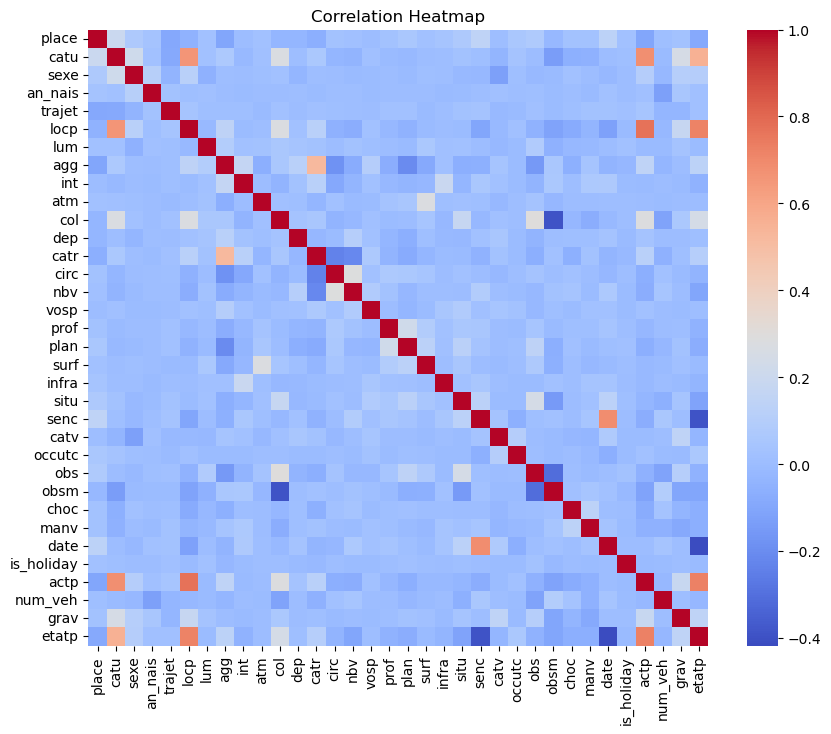

In [17]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

The correlation matrix shows some intervariable correlations.
The idea is to explore the variable gravity of the accidents as a possible target variable. 

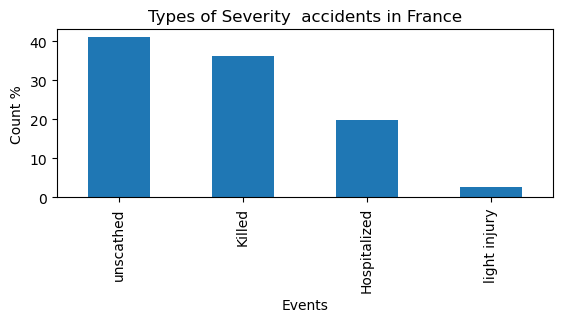

In [21]:
event_counts = df['grav'].value_counts()
event_percentages = (event_counts / event_counts.sum()) * 100
plt.subplot(2,1,1)
event_percentages.plot.bar()
labels = ['unscathed','Killed','Hospitalized','light injury']
# Add labels and title to the plot
plt.xticks(range(len(event_percentages)), labels)
plt.xlabel('Events')
plt.ylabel('Count %')
plt.title('Types of Severity  accidents in France')
# Display the plot
plt.show()

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.


In [22]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2020].drop('grav', axis = 1)
X_test = df.loc[df['an'] > 2019].drop('grav', axis = 1)

y_train = df['grav'].loc[df['an'] < 2020]
y_test = df['grav'].loc[df['an'] > 2019]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a Randon Forest classifier with 100 estimators

In [23]:
# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = clf.predict(X_test)

# Get the accuracy score
acc = accuracy_score(y_test, y_pred)

# Model Accuracy, how often is the classifier correct?
print("[Random Forest Algorithm] Accuracy Score: {:.3f}".format(acc))

# Print the classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

[Random Forest Algorithm] Accuracy Score: 0.669
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.77     92891
           1       0.40      0.03      0.05      5485
           2       0.51      0.40      0.45     33445
           3       0.64      0.68      0.66     89390

    accuracy                           0.67    221211
   macro avg       0.57      0.47      0.48    221211
weighted avg       0.66      0.67      0.66    221211



In [24]:
from sklearn.metrics import confusion_matrix
#  confusion matrix
matrix = confusion_matrix(y_test, y_pred)  #y_test_preds

# Create a DataFrame from the confusion matrix
class_names = df.grav.values
dataframe = pd.DataFrame(matrix, index=['0', '1','2','3'], 
                         columns=['0', '1','2','3'])

# Display the confusion matrix as text
print("Confusion Matrix:")
print(dataframe)

Confusion Matrix:
       0    1      2      3
0  73861   26   2121  16883
1    656  147   2881   1801
2   4124  150  13298  15873
3  20966   41   7681  60702


Length of feature_names: 37
Length of importances: 37


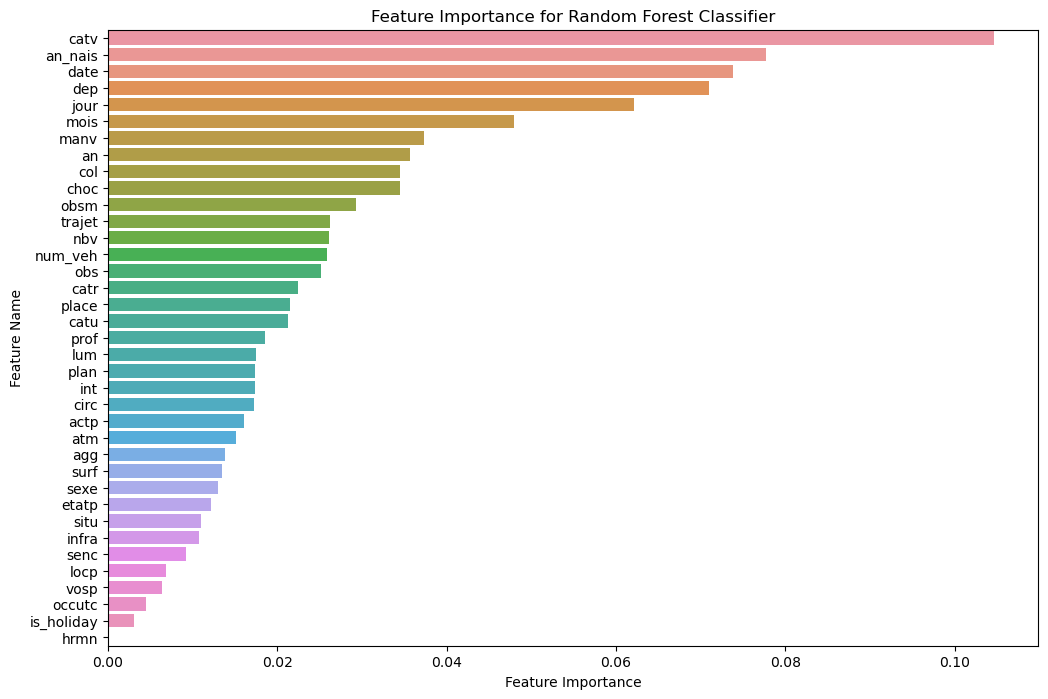

In [26]:
# estimate the feature importance for the model
import numpy as np

# Access feature importances from the trained model
importances = clf.feature_importances_

feature_names = df.drop(columns=['grav']).columns.tolist()

# Check the lengths of feature_names and importances
print("Length of feature_names:", len(feature_names))
print("Length of importances:", len(importances))

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Random Forest Classifier')
plt.show()

In [27]:
from sklearn.tree import export_text
tree_index = 0
decision_tree = clf.estimators_[tree_index]

tree_text = export_text(decision_tree,feature_names=feature_names)
print(tree_text)

|--- etatp <= 1.50
|   |--- obs <= 0.50
|   |   |--- sexe <= 1.50
|   |   |   |--- catv <= 25.50
|   |   |   |   |--- place <= 1.50
|   |   |   |   |   |--- agg <= 1.50
|   |   |   |   |   |   |--- nbv <= 2.50
|   |   |   |   |   |   |   |--- manv <= 14.50
|   |   |   |   |   |   |   |   |--- circ <= 1.50
|   |   |   |   |   |   |   |   |   |--- catr <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- num_veh <= 21.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 36
|   |   |   |   |   |   |   |   |   |   |--- num_veh >  21.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 28
|   |   |   |   |   |   |   |   |   |--- catr >  2.50
|   |   |   |   |   |   |   |   |   |   |--- obsm <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 25
|   |   |   |   |   |   |   |   |   |   |--- obsm >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 31
|   |   |   |   |   |   |   |   |

### saving the model for future use

In [28]:
import joblib
joblib.dump(clf, 'random_forest_model_3b.pkl')

['random_forest_model_3c.pkl']

### load the model 

#####  loaded_model = joblib.load('random_forest_model_3b.pkl')